# Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we explore **peak-based analysis** of synthetic XRD-CT datasets generated using the `nDTomo` package. Having already performed unsupervised analysis (e.g. PCA, NMF, clustering) on this dataset, we now focus on **quantitative extraction of diffraction peak parameters**, which is essential in many real-world applications of XRD-CT.

This step mimics the **final stage of XRD-CT data analysis**, where we move beyond general pattern recognition and into **parametric modelling of Bragg reflections** — enabling phase quantification, strain mapping, and microstructural analysis.

## 🎯 Objectives

By the end of this notebook, you will:
- Re-use the synthetic phantom XRD-CT dataset generated previously
- Perform background subtraction and identify key peaks
- Fit diffraction patterns using both single-peak and multi-peak models
- Generate 2D chemical maps based on extracted peak intensities, positions, or FWHM
- Evaluate the effectiveness of peak fitting on clean, controlled data

## 🧪 Why Peak Fitting?

While clustering and unmixing methods can reveal overall trends, **peak fitting allows you to extract phase-specific parameters** with physical meaning:

- **Peak position** → Lattice parameter / strain
- **Peak area** → Phase abundance
- **Peak width** → Crystallite size or microstrain (via Scherrer or Williamson-Hall)

These metrics are especially valuable in:
- Operando catalyst studies
- Battery material evolution
- Polymorphism detection
- Crystallinity and size analysis

Even in synthetic datasets, peak fitting provides a crucial benchmark to test the limits of resolution and accuracy.

## 📦 Dataset

We will re-use the same synthetic phantom XRD-CT dataset created earlier:

- 5 chemical components (Al, Cu, Fe, Pt, Zn)
- 2D spatial images for each component
- Simulated diffraction patterns for each pixel

The volume has shape:

$$
(x, y, q) = (200, 200, 250)
$$

where $q$ is the diffraction axis (e.g., $2\theta$ or $q$-space).

We now begin by importing the relevant packages and loading the synthetic volume.

## 🧪 Generate the Synthetic XRD-CT Phantom

Before we begin fitting diffraction peaks, we must first simulate a synthetic chemical tomography dataset using `nDTomo`. This dataset mimics the type of data produced in real XRD-CT experiments, where each pixel contains a full diffraction pattern (rather than a single intensity value).

We simulate 5 chemical components (Al, Cu, Fe, Pt, Zn), each defined by:
- A **reference diffraction pattern** (1D)
- A **2D spatial image** showing where the phase is located

These are linearly combined into a 3D dataset of shape $(x, y, q)$, where each spatial pixel has its own composite diffraction pattern.

### 📥 Load Spectra and Spatial Maps

We begin by importing the simulated diffraction patterns and the corresponding phantom images.

Next we generate a 3D synthetic XRD-CT volume by assigning spectra to spatial regions. Each pixel's diffraction pattern is a weighted sum of the reference patterns based on the phase distribution images.


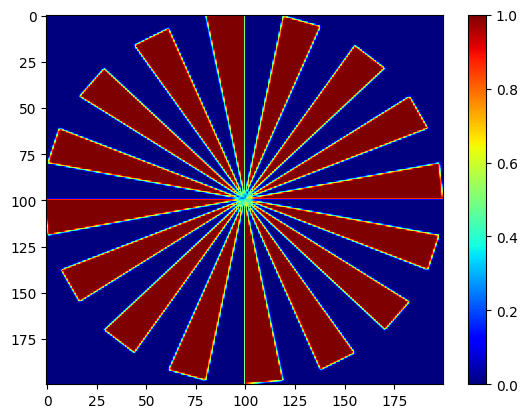

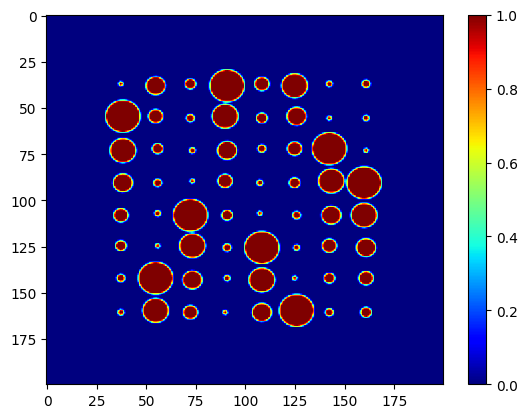

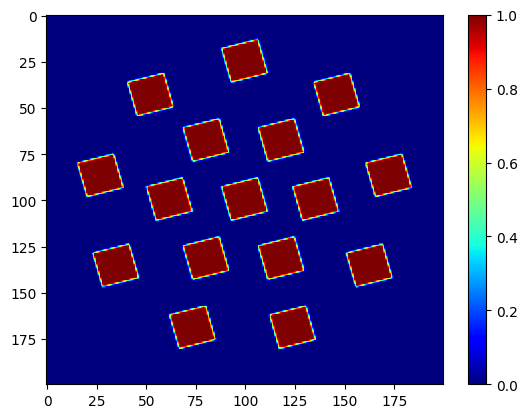

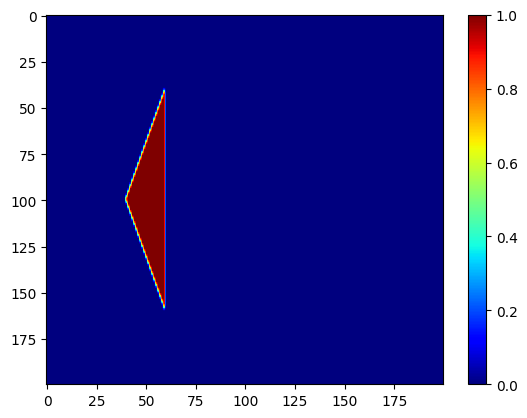

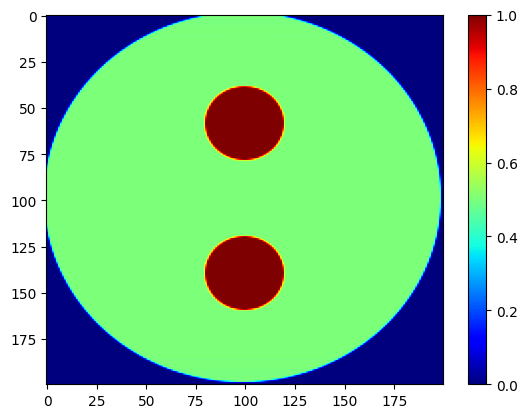

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim


# Create 2D spatial images for the five components
npix = 200
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)



In [47]:

def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
# x = np.arange(0, 5, 0.025)
# x = np.arange(0, 5, 0.075)
x = np.arange(0, 5, 0.25)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.25
peak1_sigma_max = 0.5

peak1_A_min = 0
peak1_A_max = 1

bkg_slope_min = -0.01
bkg_slope_max = 0.01

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=area[ii,jj], mu=position[ii,jj], sigma=fwhm[ii,jj]) + \
                           linear_background(x, slope=slope[ii,jj], intercept=intercept[ii,jj])

extra = 20
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))


def addpnoise3D(vol, ct):
    '''
    Adds Poisson noise to a 3D hyperspectral volume (H x W x Bands),
    noise is added per pixel-spectrum (i.e., per (i,j,:)).
    
    Parameters
    ----------
    vol : ndarray
        3D hyperspectral image (H x W x Bands), must be non-negative.
    ct : float
        Scaling constant to simulate photon counts.
    '''
    vol = vol.copy()
    mi = np.min(vol)
    if mi < 0:
        vol = vol - mi + np.finfo(np.float32).eps
    elif mi == 0:
        vol = vol + np.finfo(np.float32).eps

    # Apply Poisson noise per pixel-spectrum
    noisy = np.random.poisson(vol * ct) / ct
    return noisy

# vol = vol + 0.001*np.random.rand(vol.shape[0], vol.shape[1], vol.shape[2])
# # vol = addpnoise3D(vol, ct=1000)
# # vol = addpnoise3D(vol, ct=100)
# vol[vol<0] = 0



100%|██████████| 200/200 [00:00<00:00, 345.77it/s]

(240, 240, 20) 1.22


We can now interactively explore the spectral content of this volume using the chemimexplorer

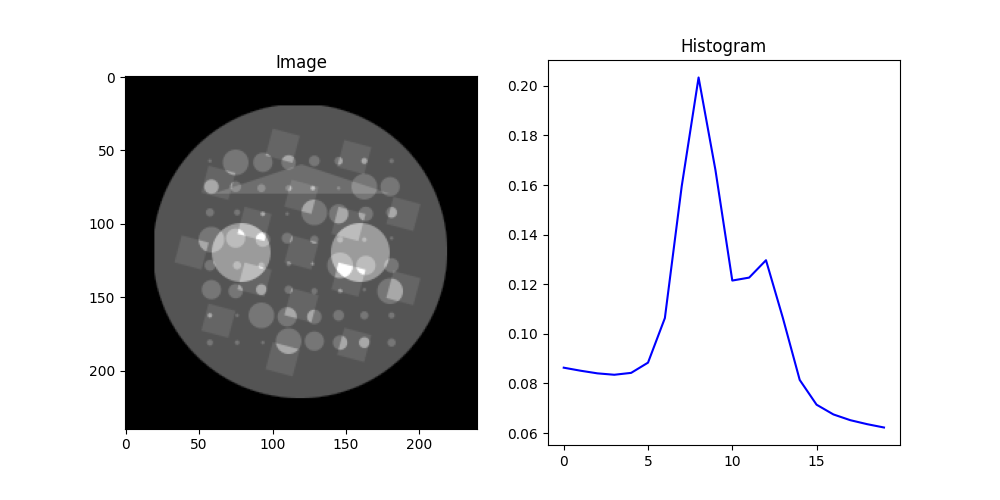

In [48]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(vol)

In [ ]:
import torch

In [ ]:

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')


### Single peak
peak_definitions = [(1, 1.0, 4.0)]

### Multiple peaks
peak_definitions = [(1, 0, 1.5),
                    (3, 1.9, 3.1),
                    (4.5, 3.9, 5.1),
                    (6, 5.9, 7.1),
                    (8, 7.9, 9.1)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'


In [ ]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()


### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 15,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1.0,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.02,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    


nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

# rand_static = torch.randn(1, nch_in, npix, npix).to(device)
im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

with torch.no_grad():
    yprms = model(im_static)
    yprms = F.interpolate(yprms, scale_factor=1/4, mode='bilinear', align_corners=False)

# yprms = yprms.detach()

# start = time.time()
# logloss = []
# patience = 100*niters_required

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

# for epoch in tqdm(range(epochs)):

#     indices = generate_indices(rows, cols, num_patches, patch_size, distribution_type, std=std_dev, mask=mask, 
#                         device='cuda', batched=True)
    
#     # yc = model(im_static)
#     # yc = calc_patches_indices(indices, yc, patch_size, use_middle=True)

#     patches = calc_patches_indices(indices, yobs, patch_size, use_middle=True)
#     yc = model(patches)

#     y = torch.zeros((patch_size*patch_size*num_patches, len(xv)), dtype=torch.float32).to(device)
    
#     for i in range(num_peaks):
#         area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
#         position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
#         fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

#         area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
#         position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
#         fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

#         area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
#         position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
#         fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
        
#         y += gaussian(xv.unsqueeze(0), area, position, fwhm)
    
#     slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
#     intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

#     slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
#     intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

#     slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
#     intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

#     y += slope * xv + intercept  

#     # patches = calc_patches_indices(indices, yobs, patch_size, use_middle=True)  
#     patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
#     patches = torch.transpose(patches, 1, 2)
#     patches = torch.transpose(patches, 1, 0)
    
#     y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

#     # #### For SSIM calculation ####
#     # patches = torch.reshape(patches, (patch_size,patch_size,patches.shape[1],patches.shape[2]))
#     # y = torch.reshape(y, (patch_size,patch_size,y.shape[1],y.shape[2]))

#     # patches = torch.transpose(patches, 2, 0)
#     # patches = torch.reshape(patches, (num_patches,patch_size*patch_size,patches.shape[3]))

#     # y = torch.transpose(y, 2, 0)
#     # y = torch.reshape(y, (num_patches,patch_size*patch_size,y.shape[3]))

#     # ssim_loss = SSIM2D()
#     # loss_ssim = 0
#     # for ii in range(y.shape[0]):
#     #     loss_ssim = loss_ssim + ssim_loss(y[ii:ii+1,:,:], patches[ii:ii+1,:,:])
#     # loss_ssim = loss_ssim/y.shape[0]

#     loss_mae =  MAE(patches, y)
#     loss_mse = torch.mean((patches - y) ** 2)
#     loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
    
#     loss = loss_rmse #+ loss_ssim
    
#     # Backpropagation
#     optimizer.zero_grad()
#     loss.backward()

#     optimizer.step()
            
#     scheduler.step(loss)
    
#     if epoch % (int(patience/2)) == 0:
#         print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
#         # print('SSIM = ', loss_ssim)
#         print('Loss = ', loss)
        
#     if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
#         print("Minimum learning rate reached, stopping the optimization")
#         print(epoch)
#         break
#     logloss.append(loss.cpu().detach().numpy())
    

##### This is using predefined indices #####

epochs = 50000
patience = 100 #250
learning_rate = 0.001
min_lr = 1E-5
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)


# learning_rate = 0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# learning_rate = 0.1
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

# yobs_1d = torch.reshape(yobs, (yobs.shape[0], yobs.shape[1], yobs.shape[2]*yobs.shape[3]))

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    # Shuffle the list
    # np.random.shuffle(new_indices)


    # #### Append a random batch at the end of the predifined indices ####
    # random_indices = generate_indices(rows, cols, num_patches, patch_size, distribution_type, std=std_dev, mask=mask_t, 
    #                     device='cuda', batched=True)
    # new_indices = indices + random_indices
    # total_indices = len(new_indices)
    # num_batches = (total_indices + num_patches - 1) // num_patches
    # random.shuffle(new_indices)
    

    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        #### Method with large layer ####
        # yc = model(im_static)
        # yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        # batch_indices = generate_indices(rows, cols, num_patches, patch_size, distribution_type, std=std_dev, mask=mask_t, 
        #                     device='cuda', batched=True)        
        # yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=True)
        yc = model_cnn(downsampled)
        # yc = model_cnn(yprms)
        

        # yc = torch.concatenate((torch.zeros((1, yc.shape[1], ofs, yc.shape[3]), dtype=torch.float32).to(device), 
        #                         yc, 
        #                         torch.zeros((1, yc.shape[1], ofs, yc.shape[3]), dtype=torch.float32).to(device)), axis = 2)
        # yc = torch.concatenate((torch.zeros((1, yc.shape[1], yc.shape[2], ofs), dtype=torch.float32).to(device),
        #                         yc, 
        #                         torch.zeros((1, yc.shape[1], yc.shape[2], ofs), dtype=torch.float32).to(device)), axis = 3)
        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)
        
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)

        # #### Method with small layer ####
        # batch_indices = generate_indices(rows, cols, num_patches, patch_size + 2*offset, distribution_type, std=std_dev, mask=mask_t, 
        #                     device='cuda', batched=True)        

        ##### applying offset to the indices for when padding is valid #####
        # patches = calc_patches_indices(batch_indices - offsets, yobs, patch_size + 2*offsets, use_middle=False)
        # ##### applying no offset to the indices for when padding is same #####
        # # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)
        # # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=True)
        # yc = model_cnn(patches)

        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)
        # patches_1d = torch.reshape(patches, (patches.shape[0], patches.shape[1], patches.shape[2]*patches.shape[3]))
        # yc = model(patches, patches_1d)
        # # yc = model(patches_1d)


        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        #### Method with large layer ####
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)  
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=True)  


        #### Method with small layer ####
        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)  
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=True)  
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)